# 2등 솔루션
1. employee 1,2의 ,를 제거하고 숫자로 변경
2. 

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import shap
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt


Bad key "axes.titlelocation" on line 10 in
C:\Users\gon2gon2\.matplotlib\stylelib\mystyle.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key "axes.titlecolor" on line 13 in
C:\Users\gon2gon2\.matplotlib\stylelib\mystyle.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
#Reading the train and test files
train_prod_df = pd.read_csv('./data/train.csv')
test_prod_df = pd.read_csv('./data/test.csv')

In [5]:
#Removing the comma in the employee1 and 2 columns in the test dataset and replace it with empty space and convert it to float format.
# test셋의 object type으로 된 애들을 str로 바꿔서 ,를 제거한 뒤 다시 float형으로 바꿔준다
test_prod_df.employee1 = test_prod_df.employee1.astype('str').str.replace(",", "").astype('float')
test_prod_df.employee2 = test_prod_df.employee2.astype('str').str.replace(",", "").astype('float')

In [6]:
#Converting the employee1 and 2 column as float in the train set as done for the test dataset
# train에 있는 애들도 혹시 모르니 float형으로 바꿔준다
train_prod_df.employee1 = train_prod_df.employee1.astype('float')
train_prod_df.employee2 = train_prod_df.employee2.astype('float')
train_prod_df.OC= train_prod_df.OC.astype('str').str.replace(" ","")

In [7]:
#Combining the train and test dataset
# train과 test 셋 병합
train_test_prod = train_prod_df.append(test_prod_df)

In [9]:
print(len(train_prod_df))
print(len(test_prod_df))

301
127


In [8]:
len(train_test_prod)

428

In [10]:
#Get the object and numeric columns seperately 
# object 칼럼과 numeric 칼럼을 각각 구한다.
factor_columns = train_test_prod.select_dtypes(include = ['object']).columns
numeric_columns = train_test_prod.columns.difference(factor_columns)

In [15]:
inst = train_test_prod['instkind']

In [17]:
bed = train_test_prod['bedCount']

In [18]:
new = pd.DataFrame({'inst':inst,'bed':bed})

In [22]:
new

,inst,bed
0,nursing_hospital,175.0
1,general_hospital,410.0
2,nursing_hospital,468.0
3,general_hospital,353.0
4,general_hospital,196.0
...,...,...
122,traditional_clinic,0.0
123,traditional_hospital,NaN
124,hospital,150.0
125,NaN,NaN


In [48]:
new['check'] = 0
for i in range(len(new)):
    n = new.iloc[i,1]
    if n >=100:
        c = '종합병원'
    elif 30<=n<100:
        c = '병원'
    elif n<=30:
        c = '의원'
    else:
        c = '한의원'
    new.iloc[i,2] = c

In [37]:
new['inst'].value_counts()

nursing_hospital        207
hospital                124
general_hospital         56
clinic                   22
traditional_hospital      9
traditional_clinic        6
dental_clinic             1
Name: inst, dtype: int64

In [27]:
new[new['instkind']=='']

In [38]:
new.head()

,inst,bed,check
0,nursing_hospital,175.0,0
1,general_hospital,410.0,0
2,nursing_hospital,468.0,0
3,general_hospital,353.0,0
4,general_hospital,196.0,0


In [44]:
enc = LE()

In [ ]:
enc.fit_transform(new['inst'])

In [52]:
for i in new['inst'].unique():
    print(i)

nursing_hospital
general_hospital
hospital
traditional_clinic
clinic
traditional_hospital
dental_clinic
nan


In [57]:
new[(new['inst']=='clinic') |\
    (new['inst']=='traditional_clinic')|\
    (new['inst']=='dental_clinic')]

,inst,bed,check
30,traditional_clinic,0.0,의원
39,clinic,0.0,의원
68,clinic,0.0,의원
73,dental_clinic,0.0,의원
110,clinic,0.0,의원
120,clinic,0.0,의원
130,traditional_clinic,0.0,의원
138,clinic,29.0,의원
165,clinic,0.0,의원
178,clinic,0.0,의원


In [62]:
new[new['inst']=='dental_clinic']

,inst,bed,check
73,dental_clinic,0.0,의원


In [61]:
pd.concat([new[new['inst']=='nursing_hospital'].head(3),\
    new[new['inst']=='general_hospital'].head(3),\
    new[new['inst']=='hospital'].head(3),\
    new[new['inst']=='traditional_hospital'].head(3)])

,inst,bed,check
0,nursing_hospital,175.0,종합병원
2,nursing_hospital,468.0,종합병원
8,nursing_hospital,280.0,종합병원
1,general_hospital,410.0,종합병원
3,general_hospital,353.0,종합병원
4,general_hospital,196.0,종합병원
13,hospital,143.0,종합병원
20,hospital,167.0,종합병원
22,hospital,48.0,병원
48,traditional_hospital,28.0,의원


The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
Glyph 51333 missing from current font.
Glyph 54633 missing from current font.
Glyph 48337 missing from current font.
Glyph 50896 missing from current font.
Glyph 51032 missing from current font.
Glyph 54620 missing from current font.
Glyph 51333 missing from current font.
Glyph 54633 missing from current font.
Glyph 48337 missing from current font.
Glyph 50896 missing from current font.
Glyph 51032 missing from current font.
Glyph 54620 missing from current font.


<Figure size 1440x1440 with 0 Axes>

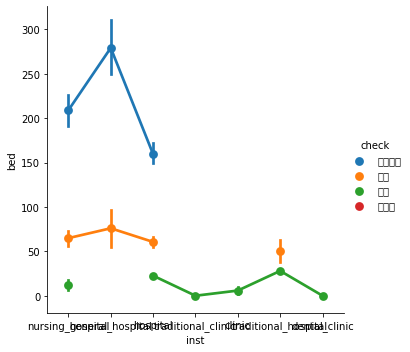

In [49]:
plt.figure(figsize=(20,20))
sns.factorplot(x='inst',y='bed',hue='check',data=new)

In [ ]:
#After analysis realized that the bed counts of these two hospitals may have had wrong entries.
#Filling up the empty instkind and bedCount for hospital id 430 and 413
train_test_prod.loc[train_test_prod.inst_id == 430, ['instkind']] = 'dental_clinic'
train_test_prod.loc[train_test_prod.inst_id == 430, ['bedCount']] = 0
train_test_prod.loc[train_test_prod.inst_id == 413, ['bedCount']] = -999

In [ ]:

#Fill the empty values in the object columns as "Not sure"
train_test_prod[factor_columns] = train_test_prod[factor_columns].fillna('Not_sure')

#Fill all the empty values in the numeric columns as -999
train_test_prod[numeric_columns] = train_test_prod[numeric_columns].fillna(-999)

In [ ]:
#Combining the train and test dataset
train_test_prod = train_prod_df.append(test_prod_df)

#Get the object and numeric columns seperately 
factor_columns = train_test_prod.select_dtypes(include = ['object']).columns
numeric_columns = train_test_prod.columns.difference(factor_columns)

#After analysis realized that the bed counts of these two hospitals may have had wrong entries.
#Filling up the empty instkind and bedCount for hospital id 430 and 413
train_test_prod.loc[train_test_prod.inst_id == 430, ['instkind']] = 'dental_clinic'
train_test_prod.loc[train_test_prod.inst_id == 430, ['bedCount']] = 0
train_test_prod.loc[train_test_prod.inst_id == 413, ['bedCount']] = -999

#Fill the empty values in the object columns as "Not sure"
train_test_prod[factor_columns] = train_test_prod[factor_columns].fillna('Not_sure')

#Fill all the empty values in the numeric columns as -999
train_test_prod[numeric_columns] = train_test_prod[numeric_columns].fillna(-999)

In [ ]:
#Convert all the object columns to numeric since the ML algorithms don't accept object features directly 
fac_le = LabelEncoder()
train_test_prod[factor_columns] = train_test_prod.loc[:,factor_columns].apply(lambda x : fac_le.fit_transform(x))

#Splitting back data to train prod and test prod
train_prod = train_test_prod.loc[train_test_prod.OC != 0,]
test_prod = train_test_prod.loc[train_test_prod.OC == 0,]
train_prod['OC'] = train_prod['OC'] - 1

#Obtain the submission ID to create the submission file later
sub_id = test_prod.inst_id

#Get the dependent and independent column
dep = 'OC'
indep = train_prod.columns.difference([dep])


train_prod_X = train_prod[indep]
train_prod_Y = train_prod[dep]
test_prod_X = test_prod[indep]